# Importing Packages

In [1]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 1s 0us/step


In [4]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [5]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [7]:
train_length = len(os.listdir(train_dir))
val_length = len(os.listdir(val_dir))
print("Train length", train_length)
print("val length", val_length)

Train length 5
val length 5


In [10]:
#Set model parametters
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

#Data preparation

In [11]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [12]:
"""
After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.
"""
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [29]:
train_length = 2935
val_length = 735

#Visualize imagens

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

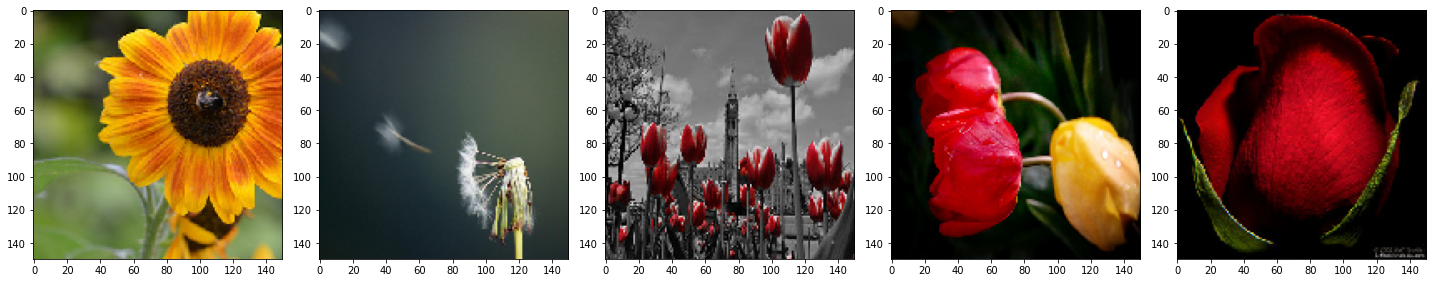

In [15]:
#Visualizing images from the data
sample_training_images, _ = next(train_data_gen) 
plotImages(sample_training_images[:5])  # Plot images 0-4

## Tecnics to avoid overfiting
## Data Augmentation


In [16]:
#Putting random rotration and zoom in train dataset
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2935 images belonging to 5 classes.


In [35]:
#Create validation generator
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 735 images belonging to 5 classes.


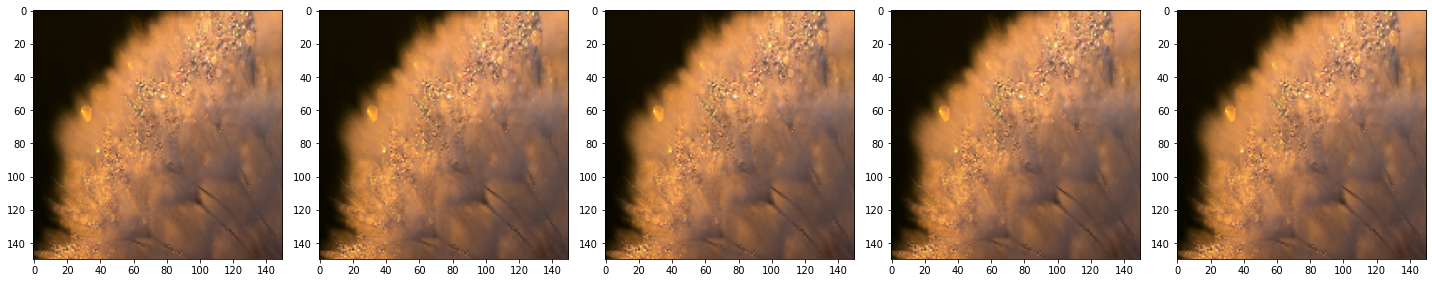

In [39]:
augmented_images = [val_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#Define model

In [48]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),        
                            
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #disaple ramdom neurons during the training to distribute the charge and avoid overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
print(train_length,val_length)

2935 735


In [51]:
#Train the model
#Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.
EPOCHS = 60
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_length / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_length / float(BATCH_SIZE))),
    callbacks=[early_stopping]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
30/30 [==============================] - 24s 739ms/step - loss: 1.4361 - accuracy: 0.3578 - val_loss: 1.2780 - val_accuracy: 0.3973
Epoch 2/60
30/30 [==============================] - 22s 731ms/step - loss: 1.2362 - accuracy: 0.4753 - val_loss: 1.0911 - val_accuracy: 0.5537
Epoch 3/60
30/30 [==============================] - 22s 731ms/step - loss: 1.1218 - accuracy: 0.5315 - val_loss: 1.0578 - val_accuracy: 0.5347
Epoch 4/60
30/30 [==============================] - 22s 735ms/step - loss: 1.0508 - accuracy: 0.5625 - val_loss: 0.9660 - val_accuracy: 0.6027
Epoch 5/60
30/30 [==============================] - 22s 735ms/step - loss: 1.0215 - accuracy: 0.5785 - val_loss: 0.9269 - val_accuracy: 0.6327
Epoch 6/60
30/30 [==============================] - 22s 742ms/step - loss: 0.9539 - accuracy: 0.6167 - val_loss: 0.9666 - val_accuracy: 0.6150
Epoch 7/60
30/30 [==============================] - 22s 737ms/step - loss: 0.9177 - accuracy: 0.6249 - val_loss: 0.8729 - val_accuracy: 0.6245

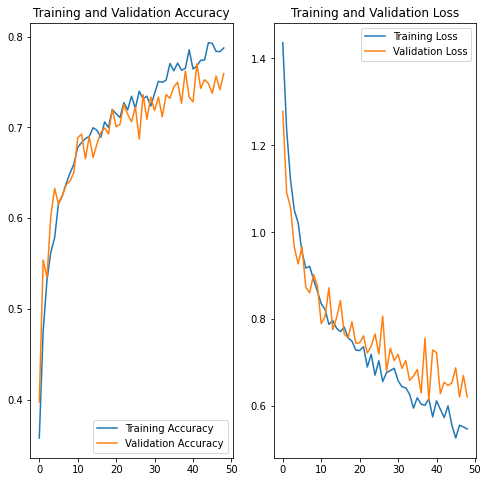

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(49)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()